In [1]:
#import libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
from sklearn.linear_model import ARDRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from autoimpute.imputations import SingleImputer
import pandas_profiling as pp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
from skfeature.function.similarity_based import fisher_score
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
# import matplotlib and set basic parameters
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

In [3]:
#read CQI dataset as dataframe
df = pd.read_csv('merged_data_cleaned.csv',header=0,index_col=False)

In [4]:
print(df.shape)
print(df.dtypes)

(1339, 44)
Unnamed: 0                 int64
Species                   object
Owner                     object
Country.of.Origin         object
Farm.Name                 object
Lot.Number                object
Mill                      object
ICO.Number                object
Company                   object
Altitude                  object
Region                    object
Producer                  object
Number.of.Bags             int64
Bag.Weight                object
In.Country.Partner        object
Harvest.Year              object
Grading.Date              object
Owner.1                   object
Variety                   object
Processing.Method         object
Aroma                    float64
Flavor                   float64
Aftertaste               float64
Acidity                  float64
Body                     float64
Balance                  float64
Uniformity               float64
Clean.Cup                float64
Sweetness                float64
Cupper.Points            float64

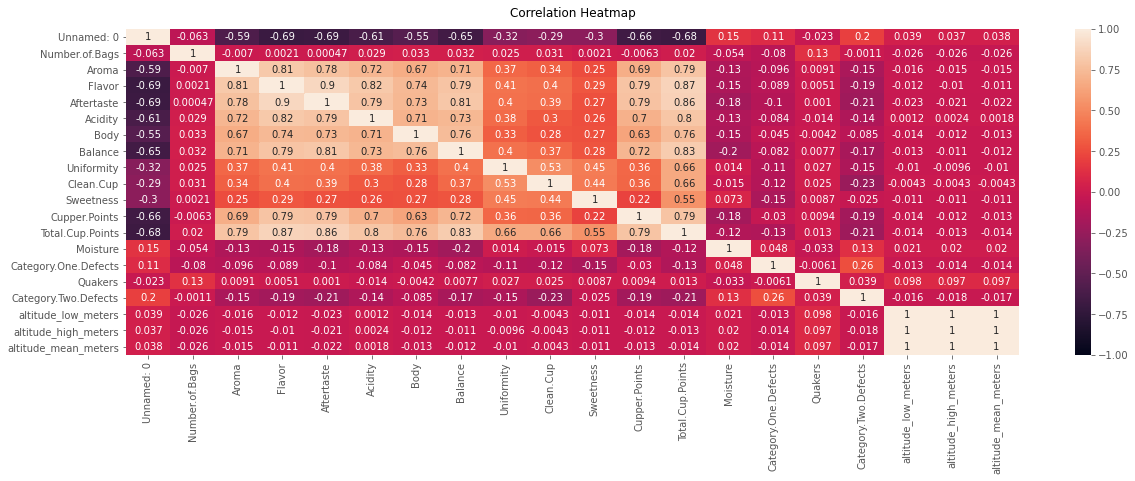

In [5]:
#check for basic pearson correlation of the CQI dataset
plt.figure(figsize=(20, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig('correlation_map.png', bbox_inches='tight')

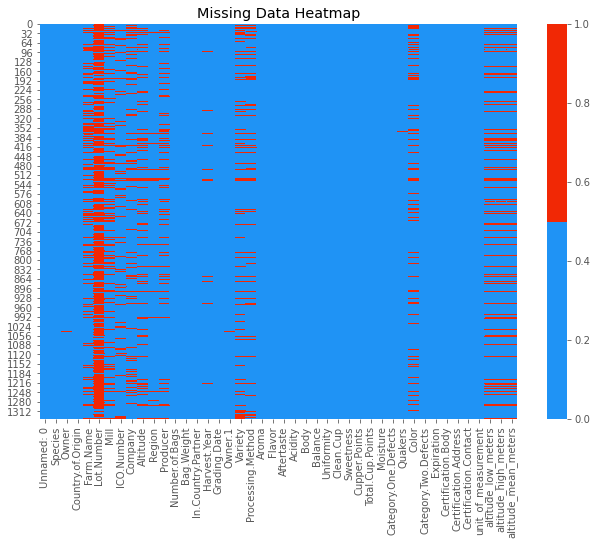

In [6]:
#check for missing data in a heatmap
colours = ['#1F93F5', '#F12805'] #blue is not missing, red is missing
sns_heatmap = sns.heatmap(df.isnull(), cmap=sns.color_palette(colours)).set_title('Missing Data Heatmap')
sns_heatmap.figure.set_size_inches(10.7, 7.27)
sns_heatmap.figure.savefig('missing_data.png')

In [7]:
#check for missing data in percentage
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col,(pct_missing*100)))

Unnamed: 0 - 0.0%
Species - 0.0%
Owner - 0.5227781926811054%
Country.of.Origin - 0.07468259895444362%
Farm.Name - 26.81105302464526%
Lot.Number - 79.38760268857357%
Mill - 23.749066467513067%
ICO.Number - 11.725168035847648%
Company - 15.608663181478716%
Altitude - 16.878267363704257%
Region - 4.4062733383121735%
Producer - 17.32636295743092%
Number.of.Bags - 0.0%
Bag.Weight - 0.0%
In.Country.Partner - 0.0%
Harvest.Year - 3.51008215085885%
Grading.Date - 0.0%
Owner.1 - 0.5227781926811054%
Variety - 16.878267363704257%
Processing.Method - 12.696041822255413%
Aroma - 0.0%
Flavor - 0.0%
Aftertaste - 0.0%
Acidity - 0.0%
Body - 0.0%
Balance - 0.0%
Uniformity - 0.0%
Clean.Cup - 0.0%
Sweetness - 0.0%
Cupper.Points - 0.0%
Total.Cup.Points - 0.0%
Moisture - 0.0%
Category.One.Defects - 0.0%
Quakers - 0.07468259895444362%
Color - 16.280806572068705%
Category.Two.Defects - 0.0%
Expiration - 0.0%
Certification.Body - 0.0%
Certification.Address - 0.0%
Certification.Contact - 0.0%
unit_of_measurement

In [8]:
#Renaming columns to python standards
df.rename(columns = {'Country.of.Origin' : 'origin', 'Processing.Method' : 'pro_method','Category.One.Defects' : 'cat1_def', 'Category.Two.Defects' : 'cat2_def','Total.Cup.Points': 'total_cup_points', 'Cupper.Points' : 'cupper_points', 'Clean.Cup' : 'clean_cup', 'Quakers' : 'quakers', 'Color' : 'color'}, inplace = True)

#dropping quakers and origin missing cases
df=df.dropna(how='any', subset=['origin', 'quakers'])

#transform altitude from feet to meters
df['altitude_low_meters'] = np.where(df['unit_of_measurement']=='ft', df['altitude_low_meters'] * 0.3048, df['altitude_low_meters'])
df['altitude_high_meters'] = np.where(df['unit_of_measurement']=='ft', df['altitude_high_meters'] * 0.3048, df['altitude_high_meters'])
df['altitude_mean_meters'] = np.where(df['unit_of_measurement']=='ft', df['altitude_mean_meters'] * 0.3048, df['altitude_mean_meters'])

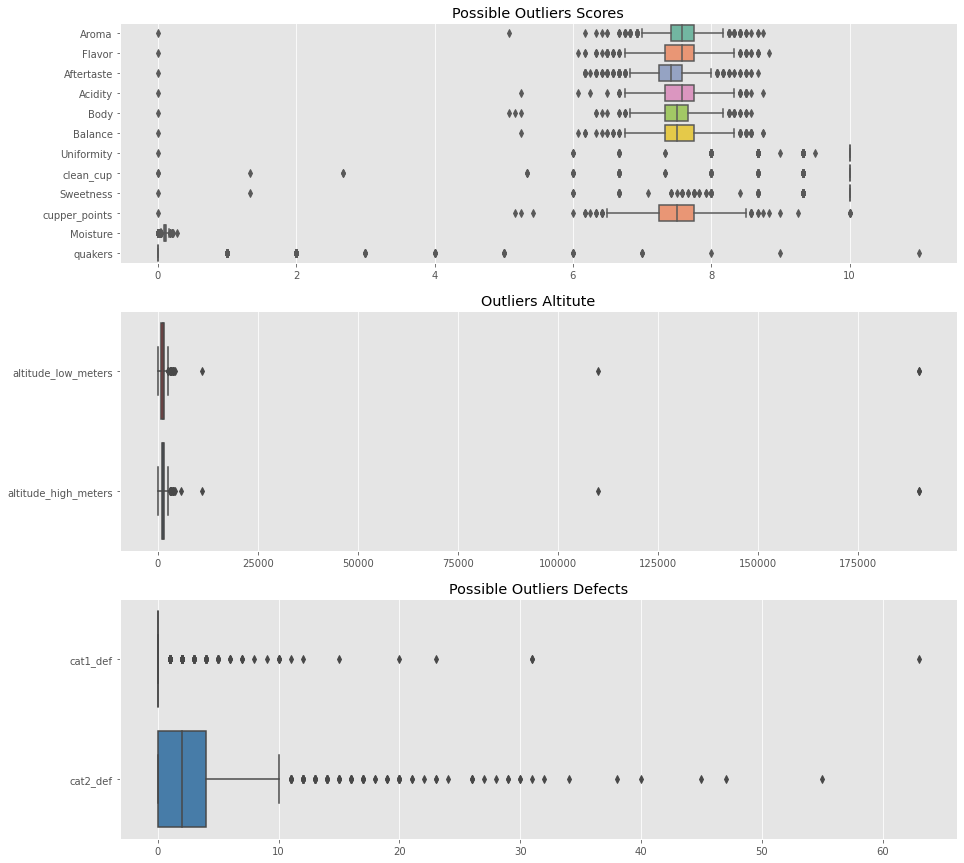

In [9]:
#check for possible outliers
fig, axs = plt.subplots(nrows=3,figsize=(15,15))
sns.boxplot(data=df.drop(['total_cup_points','Number.of.Bags','Unnamed: 0','altitude_high_meters','altitude_low_meters','altitude_mean_meters','cat1_def','cat2_def'], axis=1), orient="h", palette="Set2",ax=axs[0]).set_title('Possible Outliers Scores')
sns.boxplot(data=df[['altitude_low_meters','altitude_high_meters']], orient="h", palette="Set1",ax=axs[1]).set_title('Outliers Altitute')
sns.boxplot(data=df[['cat1_def','cat2_def']], orient="h", palette="Set1",ax=axs[2]).set_title('Possible Outliers Defects')
fig.savefig('outlier_detection')

In [10]:
#delete outlier cases of altitude
df.loc[df.altitude_high_meters >= 3000, 'altitude_high_meters'] = 'None'
df.loc[df.altitude_low_meters >= 3000, 'altitude_low_meters'] = 'None'
df.loc[df.altitude_mean_meters >= 3000, 'altitude_mean_meters'] = 'None'

In [11]:
#replace values of 'None' to NaN for treatment
df.replace(to_replace=['None'], value=np.nan, inplace=True)

In [12]:
#dropping columns that are not adding value in a real world evaluation or missing data is too much.
drop_col =['Altitude','altitude_mean_meters', 'unit_of_measurement', 'Variety', 'Region', 'Owner','Farm.Name','Lot.Number','Mill','ICO.Number','Company','Producer','Harvest.Year','Owner.1','Number.of.Bags','Bag.Weight','In.Country.Partner','Grading.Date','Certification.Body','Certification.Address','Certification.Contact','Expiration','Unnamed: 0']
df = df.drop(drop_col, axis=1)

In [13]:
#Create numeric variables df for multivariate imputation with sklearn
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values

#selecting non numerical variables
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values

In [14]:
#create names of column list
df_names = np.concatenate((non_numeric_cols,numeric_cols))

In [15]:
#replacing altitute missing values with multiple inputation
imput_func = IterativeImputer(estimator=ARDRegression(n_iter=100),sample_posterior=True, random_state=7, min_value = 0)
imput_func.fit(df_numeric)
df_numeric=(pd.DataFrame(imput_func.transform(df_numeric), columns = df_numeric.columns))

In [16]:
#Merge again df back together
df= np.concatenate((df_non_numeric,df_numeric),axis=1)
df= pd.DataFrame(data=df, columns=df_names)

In [17]:
#Create specialty coffee quality dummy variable and drop original score
df['quality'] = np.where(df['total_cup_points'] > 80, 1 , 0)
df = df.drop('total_cup_points', axis=1)

In [18]:
#Create species dummy variable 0=Robusta 1=Arabica
df['Species'] = np.where(df['Species'] == 'Arabica', 1 , 0)

In [19]:
print(df['Species'])

0       1
1       1
2       1
3       1
4       1
       ..
1332    0
1333    0
1334    0
1335    0
1336    0
Name: Species, Length: 1337, dtype: int32


In [20]:
#use of logistic regression for multivariate categorical imputation
df = SingleImputer(strategy ={'color':'categorical','pro_method':'categorical'},seed=140).fit_transform(df)

In [21]:
print(df.shape)
print(df.dtypes)

(1337, 21)
Species                  int32
origin                  object
pro_method              object
color                   object
Aroma                   object
Flavor                  object
Aftertaste              object
Acidity                 object
Body                    object
Balance                 object
Uniformity              object
clean_cup               object
Sweetness               object
cupper_points           object
Moisture                object
cat1_def                object
quakers                 object
cat2_def                object
altitude_low_meters     object
altitude_high_meters    object
quality                  int32
dtype: object


In [22]:
print (pd.DataFrame({'Percentage': df.groupby(('quality')).size() / len(df)}))
    

         Percentage
quality            
0          0.145101
1          0.854899


In [23]:
#one hot encoding processing method and color
pro_method = pd.get_dummies(df.pro_method, prefix = 'method')
color=pd.get_dummies(df.color, prefix = 'color')
country= pd.get_dummies(df.origin)
categorical_encoded = pd.DataFrame(data=np.concatenate((pro_method,color),axis=1),columns=np.concatenate((pro_method.columns.values,color.columns.values)))
df_enc= pd.DataFrame(data=np.concatenate((categorical_encoded,df),axis=1), columns=np.concatenate((categorical_encoded.columns.values,df.columns.values)))
cat_origin = pd.DataFrame(data=np.concatenate((pro_method,color,country),axis=1),columns=np.concatenate((pro_method.columns.values,color.columns.values,country.columns.values)))
df_origin= pd.DataFrame(data=np.concatenate((cat_origin,df),axis=1), columns=np.concatenate((cat_origin.columns.values,df.columns.values)))
df_enc = df_enc.apply(pd.to_numeric, errors='coerce')
df_enc = df_enc.drop(['pro_method','color', 'origin'],  axis=1)

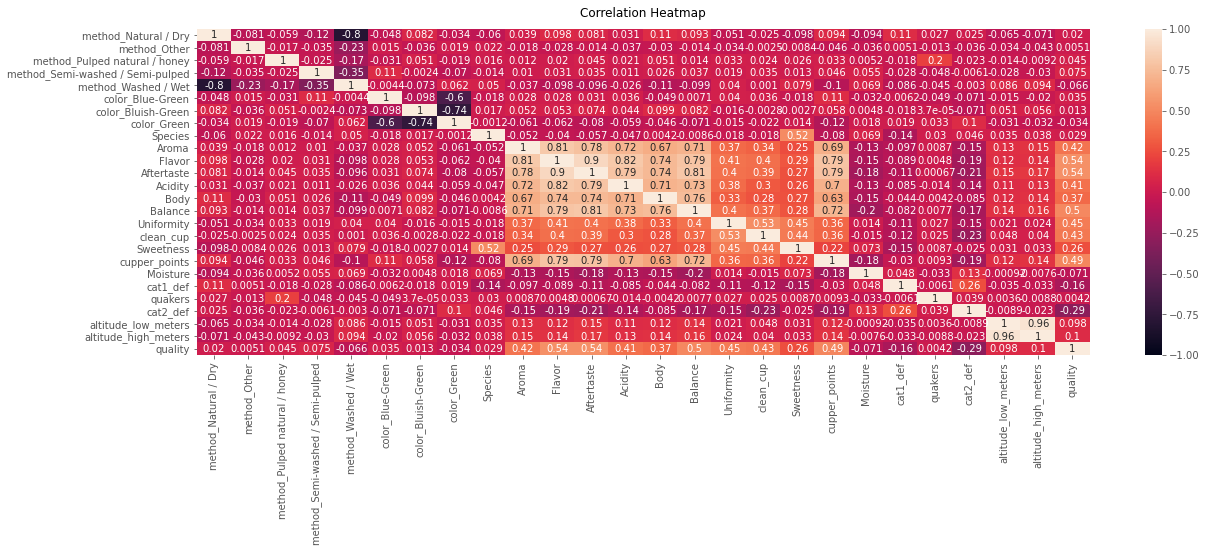

In [24]:
#check for correlations after categorical encoding
plt.figure(figsize=(20, 6))
heatmap = sns.heatmap(df_enc.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig('correlation_map.png', bbox_inches='tight')

In [25]:
#check for amount of countries
cnt = 0
visited = []
for i in range(0, len(df['origin'])):
    
    if df['origin'][i] not in visited: 
        
        visited.append(df['origin'][i])
          
        cnt += 1
print("No.of.unique values :",
      cnt)

No.of.unique values : 36


In [26]:
X = df_enc.drop(labels=['quality'], axis=1)
y = df_enc['quality']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)


In [27]:
#standard scale all of the independent data
scaler = StandardScaler()
scaler.fit(X.fillna(0))

StandardScaler()

In [28]:
#split in train/test the CQI dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train.shape, X_test.shape

((1828, 25), (458, 25))

In [29]:
Quality = y

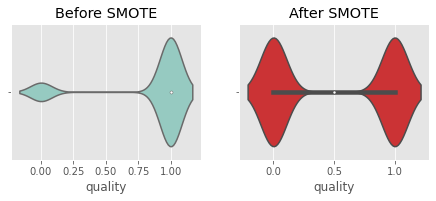

In [30]:
fig, axs = plt.subplots(ncols=2,figsize=(7.5,2.5))
sns.violinplot(x=df['quality'],ax=axs[0],palette="Set3").set_title('Before SMOTE')
sns.violinplot(x=Quality,ax=axs[1],palette="Set1").set_title('After SMOTE')
fig.savefig('SMOTE balanced')

In [31]:
#convert X and y to numpy for checking fisher scores
ind= X.to_numpy()
y_hat= y.to_numpy()

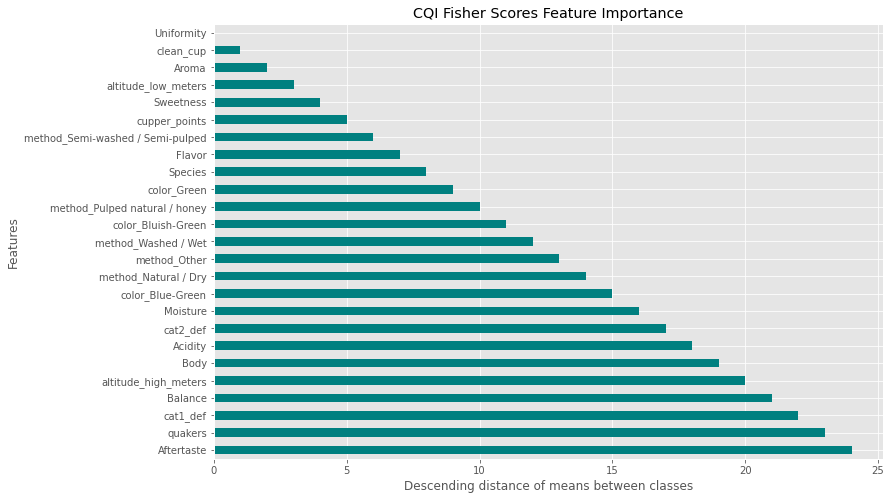

In [32]:
#Set baseline with feature importance ranking with a Fischer Score Analysis
ranks= fisher_score.fisher_score(ind,y_hat)

FS_importance = pd.Series (ranks, df_enc.columns[0:len(df_enc.columns)-1]).sort_values(ascending=False)
fig = FS_importance.plot(kind="barh",color='teal').get_figure()
plt.style.use('seaborn-colorblind')
plt.title("CQI Fisher Scores Feature Importance")
plt.xlabel("Descending distance of means between classes")
plt.ylabel("Features")
fig.savefig('CQI_Fisher.jpg', bbox_inches='tight')
plt.show()

In [33]:
FS_importance_list= pd.Series (ranks, df_enc.columns[0:len(df_enc.columns)-1]).sort_values(ascending=True)

In [34]:
#Establish possible common values for tuning booster of XGBooster
params = {
        'n_estimators':[100, 200, 300],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'lambda': [0.5, 1, 1.5],
        'alpha': [0.5, 1, 1.5]        
        }
folds = 10
param_comb = 8
xgb = XGBClassifier(learning_rate=0.01, objective='binary:logistic', nthread=1)
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 7)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,y), random_state=7 )
random_search.fit(X,y)

[13:52:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001E50E24D190>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.01,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, mis...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=

In [35]:
#Extract the best parameters for the XGB classifier
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 Best estimator:
XGBClassifier(alpha=1.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='', lambda=0.5,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=1.5, reg_lambda=0.5, scale_pos_weight=1,
              subsample=0.6, tree_method='exact', validate_parameters=1,
              verbosity=None)

 Best normalized gini score for 10-fold search with 8 parameter combinations:
0.9970137968873367

 Best hyperparameters:
{'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 4, 'lambda': 0.5, 'gamma': 1, 'colsample_bytree': 0.6, 'alpha': 1.5}


In [36]:
#set the parameters for the model
params = {
        'subsample': 0.6, 
        'n_estimators': 300, 
        'min_child_weight': 1, 
        'max_depth': 4, 
        'lambda': 1.5, 
        'gamma': 2, 
        'colsample_bytree': 0.8, 
        'alpha': 1.5,
        'use_label_encoder': False
         }
# instantiate the classifier 
xgb_clf = XGBClassifier(**params, random_state = 7)
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 7)
output = cross_validate(xgb_clf, X, y, cv=skf.split(X,y), scoring = 'accuracy', return_estimator =True)

[13:52:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [37]:
lista=[]
for ind,estimator in enumerate(output['estimator']):
    #print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = list(X.columns),
                                        columns=['importance']).sort_values('importance', ascending=False)
    lista.append(feature_importances)

In [38]:
#Create table with accuracy table from 10 folds
XGB_clf_imp= pd.concat([lista[0],lista[1],lista[2],lista[3],lista[4],lista[5],lista[6],lista[7],lista[8],lista[9]], axis=1)

#Create column and sort by average
XGB_clf_imp['Average'] = XGB_clf_imp.mean(axis=1)
XGB_clf_imp = XGB_clf_imp.loc[:,['Average']].sort_values('Average', ascending=False)


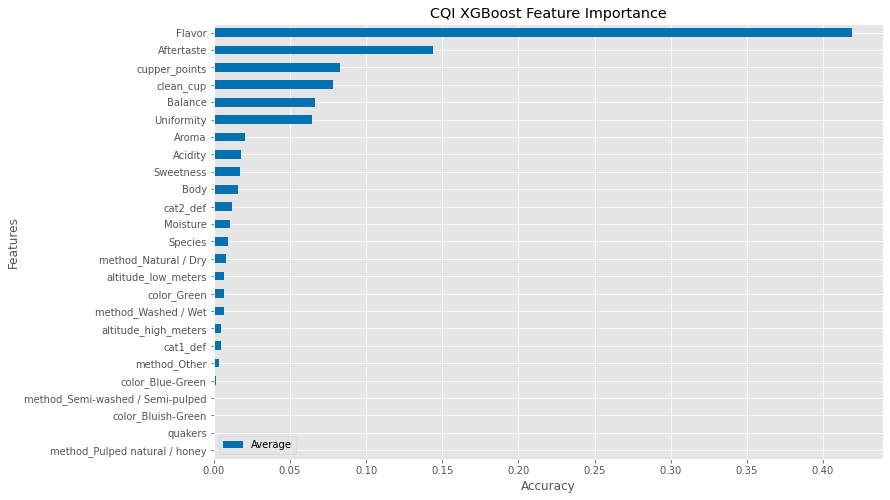

In [39]:
#plot XGB importance of CQI dataset
fig = XGB_clf_imp.sort_values('Average', ascending=True).plot(kind="barh").get_figure()
plt.style.use('seaborn-colorblind')
plt.title("CQI XGBoost Feature Importance")
plt.xlabel("Accuracy")
plt.ylabel("Features")
fig.savefig('CQI_XGBoost.jpg', bbox_inches='tight')
plt.show()

In [40]:
#Test accuracy of Random Forest with all features of coffee quality institute dataset
params={'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

cqi_clf = RandomForestClassifier(**params, random_state=7)
cqi_clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(cqi_clf.score(X_test, y_test)))

Accuracy on test data: 0.98


In [41]:
#Perform feature permutation
cqi_result = permutation_importance(cqi_clf, X_train, y_train, n_repeats=100, random_state=7)
#Sort by index the features
cqi_perm_sorted_idx = cqi_result.importances_mean.argsort()

cqi_tree_importance_sorted_idx = np.argsort(cqi_clf.feature_importances_)
cqi_tree_indices = np.arange(0, len(cqi_clf.feature_importances_)) 



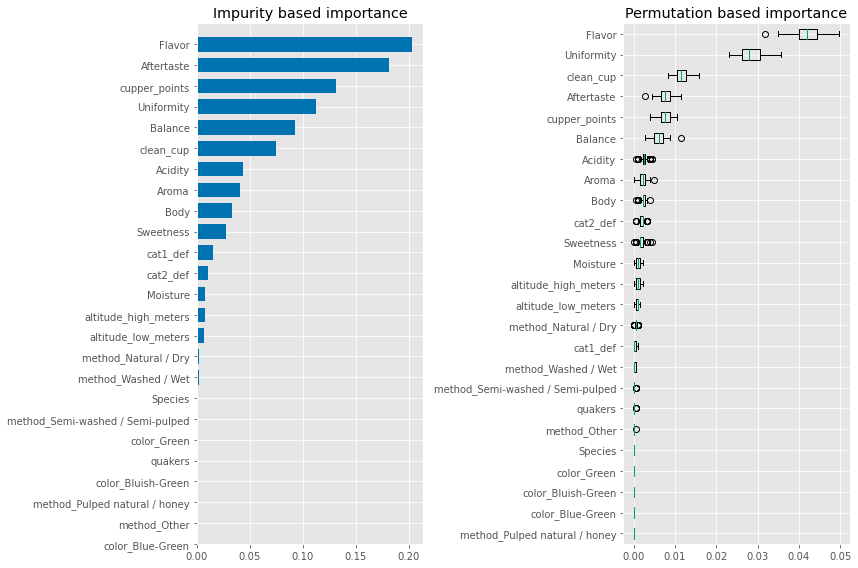

In [42]:
#plot feature permutation in comparison to impurity based importance built in the random foreset (taken from SkLearn)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(cqi_tree_indices,
         cqi_clf.feature_importances_[cqi_tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(cqi_tree_indices)
ax1.set_yticklabels([list(X.columns)[i] for i in cqi_tree_importance_sorted_idx])
ax1.set_ylim((0, len(cqi_clf.feature_importances_)))
ax1.set_title('Impurity based importance')
ax2.boxplot(cqi_result.importances[cqi_perm_sorted_idx].T, vert=False,
            labels=[list(X.columns)[i] for i in cqi_perm_sorted_idx])
ax2.set_title('Permutation based importance')
fig.tight_layout()
plt.savefig('feature_perm_cqi.png', bbox_inches='tight')
plt.show()

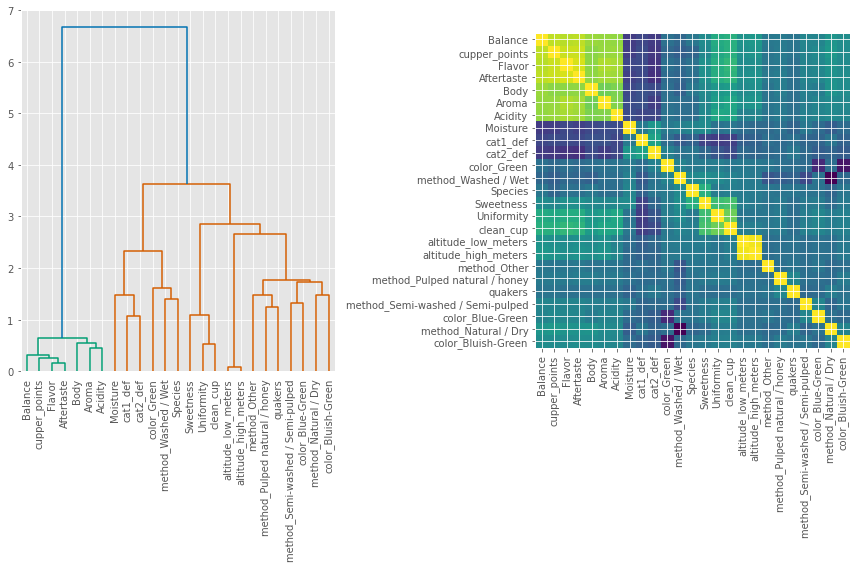

In [43]:
#Build hierarchical clustering for checking extrinsic influence in scoring
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=list(X.columns), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [44]:
#Check for classification capability of second level of clusters 
cluster_ids = hierarchy.fcluster(corr_linkage, 2, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features1 = [v[1] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train.iloc[:, selected_features]
X_test_sel = X_test.iloc[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=7)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 0.95


In [45]:
#Extracted ranking from Fischer Scores
fs_rank=list(FS_importance.sort_values(ascending=True).index)

#Extracted ranking from feature Permutation
feat_perm_rank=[list(X.columns)[i] for i in cqi_perm_sorted_idx][::-1]

#Extracted ranking from XGBoost
xgb_rank=list(XGB_clf_imp.index.values)

#Extracted features from hierarchical clustering
clustering_feat1 = list(X.iloc[:, selected_features].columns)
clustering_feat2 = list(X.iloc[:, selected_features1].columns)


In [46]:
#Function that test how performance change by adding one feature to a model with 1,2,3 k-Neighbors and its change in accuracy
def full_classifier(X, y, feat_rank,to_drop):
    alist=[]
    rank = feat_rank 
    X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
    neighbors= 7
    
    while neighbors > 2:
        scores = []    
        knn = KNeighborsClassifier(n_neighbors=neighbors)
        neighbors -=2
        feat_drop= to_drop
        alist.append(scores)
        counter = 0
        while counter < feat_drop:
            knn.fit(X_train[rank[counter:-1]], y_train)
            y_pred = knn.predict(X_test[rank[counter:-1]])
            counter +=1
            score = metrics.accuracy_score(y_test, y_pred)*100
            scores.append(score)
    result = pd.DataFrame(alist, columns=[['Full_set']+rank[0:counter-1]], index=['7 Neighbors','5 Neighbors','3 Neighbors'])
    result.loc['average'] = result.mean()
    return result

In [47]:
#Function that test how performance change by adding one feature to a model with 1,2,3 k-Neighbors and its change in accuracy
def feat_classifier(X, y, feat_rank,to_drop):
    alist=[]
    rank = feat_rank 
    X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
    neighbors= 7
    
    while neighbors > 2:
        scores = []    
        knn = KNeighborsClassifier(n_neighbors=neighbors)
        neighbors -=2
        feat_drop= to_drop
        alist.append(scores)
        counter = 0
        while counter < feat_drop:
            knn.fit(X_train[rank[counter:10]], y_train)
            y_pred = knn.predict(X_test[rank[counter:10]])
            counter +=1
            score = metrics.accuracy_score(y_test, y_pred)*100
            
            scores.append(score)
    result = pd.DataFrame(alist, columns=[['Full_set']+rank[0:counter-1]], index=['7 Neighbors','5 Neighbors','3 Neighbors'])
    result.loc['average'] = result.mean()
    return result

In [48]:
#Estimate the accuracy with kNN for the rank with Fischer Scores
rank_FS_feat = feat_classifier(X, y, list(fs_rank),9)
rank_FS_full = full_classifier(X, y, list(fs_rank),9)

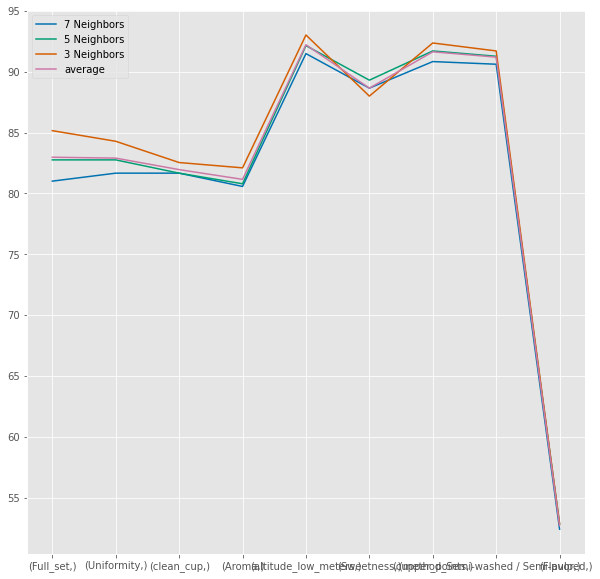

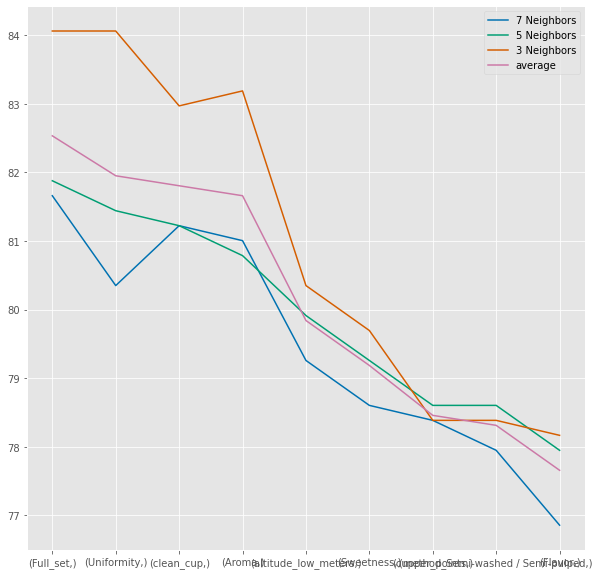

In [49]:
fig, (ax1, ax2)
plt.rcParams["figure.figsize"] = [10,10]
ax1 = rank_FS_feat.T.plot()
ax2 = rank_FS_full.T.plot()


plt.show()

In [50]:
#Estimate the accuracy with kNN for the rank with XGBoost
evaluation_xgb_feat = feat_classifier(X, y, xgb_rank, 9)
evaluation_xgb_full = full_classifier(X, y, xgb_rank, 9)

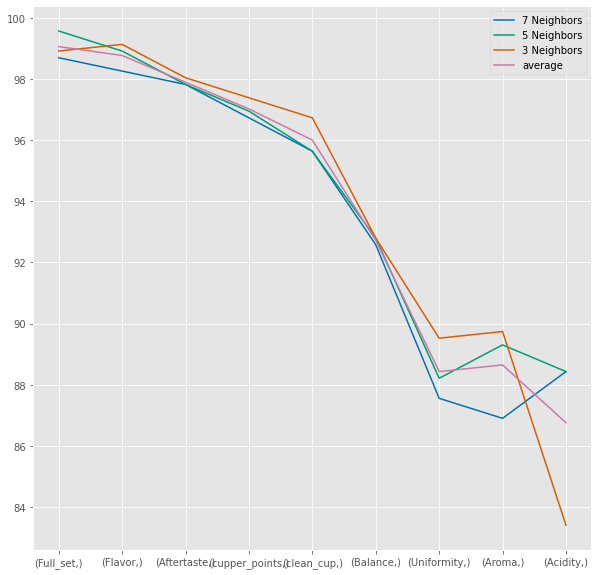

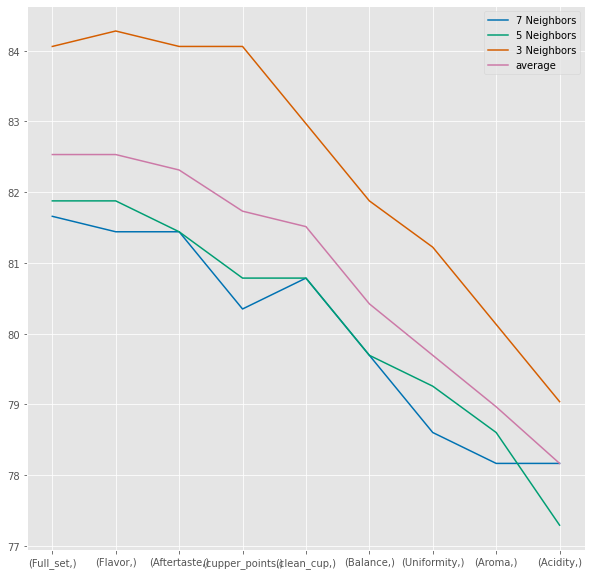

In [51]:
fig, (ax1, ax2)
plt.rcParams["figure.figsize"] = [10,10]
ax1 = evaluation_xgb_feat.T.plot()
ax2 = evaluation_xgb_full.T.plot()


plt.show()

In [52]:
evaluation_xgb_feat_back = feat_classifier(X, y, xgb_rank[0:10][::-1], 9)
evaluation_xgb_full_back = full_classifier(X, y, xgb_rank[0:10][::-1], 9)

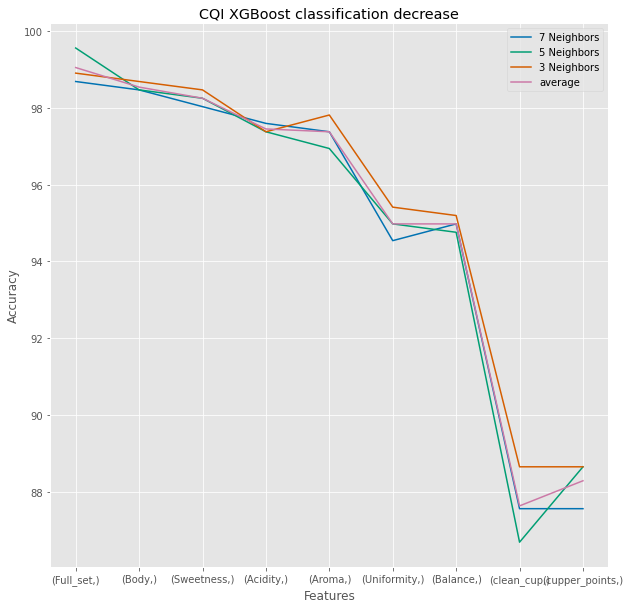

In [53]:
fig = (evaluation_xgb_feat_back.T).plot()
plt.style.use('seaborn-colorblind')
plt.title("CQI XGBoost classification decrease")
plt.xlabel("Features")
plt.ylabel("Accuracy")
plt.savefig('CQI_XGBoost_classification_d', bbox_inches='tight')
plt.show()


In [54]:
#Estimate the accuracy with kNN for the rank with Feature Permutation
eval_perm_feat = feat_classifier(X, y, feat_perm_rank, 9)
eval_perm_feat_back = feat_classifier(X, y, feat_perm_rank[:10][::-1], 9)

In [55]:
eval_perm_feat_full = full_classifier(X, y, feat_perm_rank, 9)
eval_perm_feat_full_back = full_classifier(X, y, feat_perm_rank[::-1], 9)

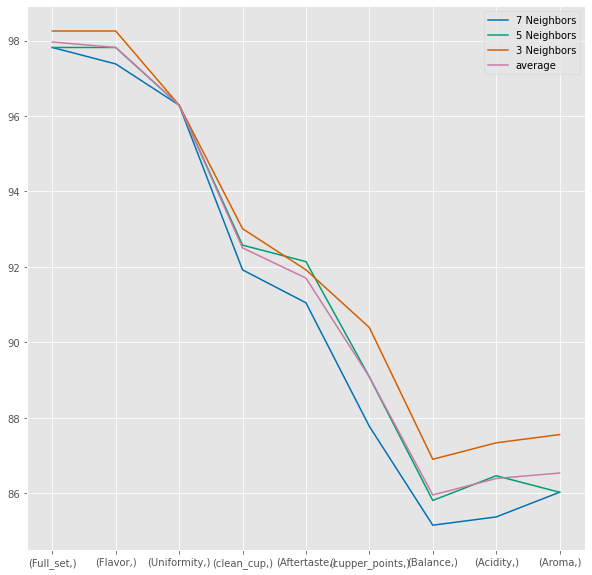

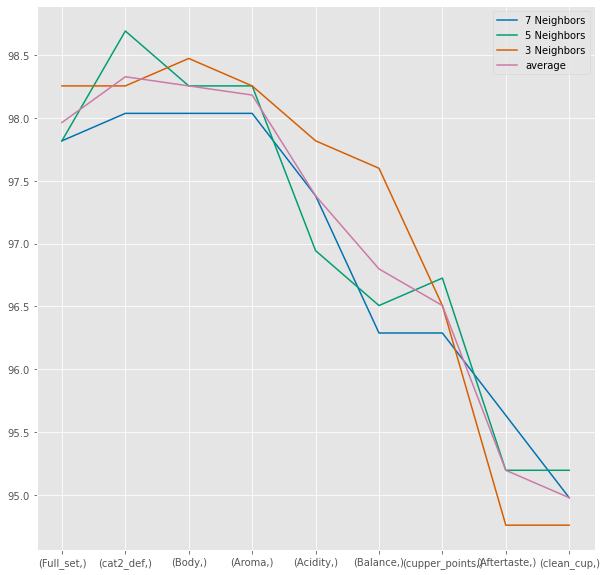

In [56]:
fig, (ax1, ax2)
plt.rcParams["figure.figsize"] = [10,10]
ax1 = eval_perm_feat.T.plot()
ax2 = eval_perm_feat_back.T.plot()


plt.show()

In [57]:
#Estimate the accuracy with kNN for the rank with Hierarchical Clustering
clus_feat1 = feat_classifier(X, y, clustering_feat1, 5)
clus_feat1_back = feat_classifier(X, y, clustering_feat1[::-1], 5)

In [58]:
clus_feat2 = feat_classifier(X, y, clustering_feat2, 5)
clus_feat2_back = feat_classifier(X, y, clustering_feat2[::-1], 5)

In [59]:
clus_feat1

,Full_set,method_Natural / Dry,method_Washed / Wet,Aroma,Uniformity
7 Neighbors,77.510917,77.510917,78.820961,74.454148,68.995633
5 Neighbors,77.510917,77.510917,79.475983,74.235808,72.270742
3 Neighbors,79.257642,77.947598,79.912664,75.109170,68.777293
average,78.093159,77.656477,79.403202,74.599709,70.014556


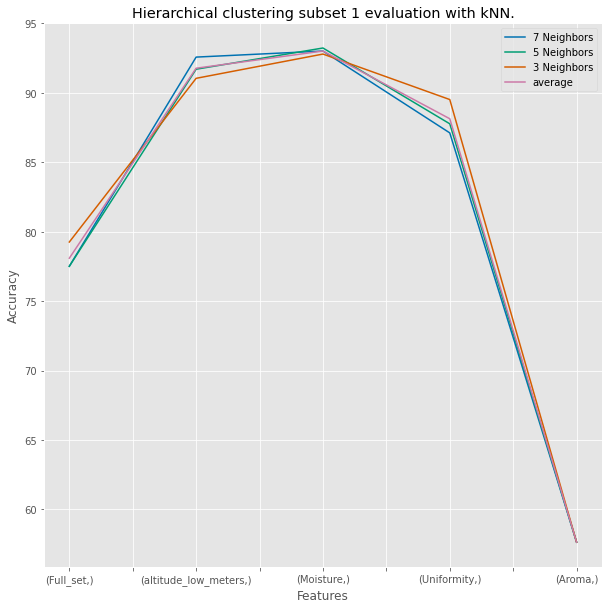

In [60]:
fig = (clus_feat1_back.T).plot()
plt.style.use('seaborn-colorblind')
plt.title("Hierarchical clustering subset 1 evaluation with kNN.")
plt.xlabel("Features")
plt.ylabel("Accuracy")
plt.savefig('wards linkage.png', bbox_inches='tight')
plt.show()

In [61]:
#read sweet marias dataset
df_sw = pd.read_csv('Sweet_Marias_coffee.csv', sep=",", decimal=".",header=0,index_col=False)

In [62]:
#check for basic description
df_sw.describe()

,Price,Q-Score,Fragrance,Aroma,Brightness,Flavor,Body,Finish,Sweetness,Clean Cup,Complexity,Uniformity,Cuppers Correction,Final
count,310.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,6.507742,87.822293,8.527616,8.712298,8.444854,8.762631,8.808178,8.492553,8.560745,8.252085,8.736631,8.373428,2.151274,87.483634
std,1.194461,1.838307,0.355268,0.336137,0.423959,0.338313,0.310535,0.362628,0.220917,0.431263,0.538495,0.275461,1.066577,1.846176
min,5.250000,83.400000,7.399973,7.897541,6.755053,7.867184,8.013858,7.058517,7.858014,6.075530,7.029391,7.711258,0.000000,84.486847
25%,6.050000,86.600000,8.305794,8.520999,8.319789,8.525504,8.614130,8.305860,8.470378,8.106957,8.385382,8.192537,1.500000,86.212483
50%,6.350000,87.300000,8.503761,8.709019,8.514965,8.710041,8.810156,8.513528,8.562100,8.375986,8.763048,8.441059,2.000000,86.942972
75%,6.750000,88.500000,8.703832,8.805376,8.707791,8.900733,9.034911,8.705319,8.671064,8.497504,9.091530,8.493197,2.000000,88.149632
max,17.650000,93.400000,9.679431,9.723152,9.596396,9.784969,9.523048,9.512979,9.573215,9.511536,9.983818,9.467937,8.000000,93.106716


In [63]:
#one hot encode for quality
df_sw['Quality'] = np.where(df_sw['Q-Score'] > 90, 1 , 0)
df_sw = df_sw.drop(['Q-Score','Final'], axis=1)

Text(0.5, 1.0, 'Imbalance')

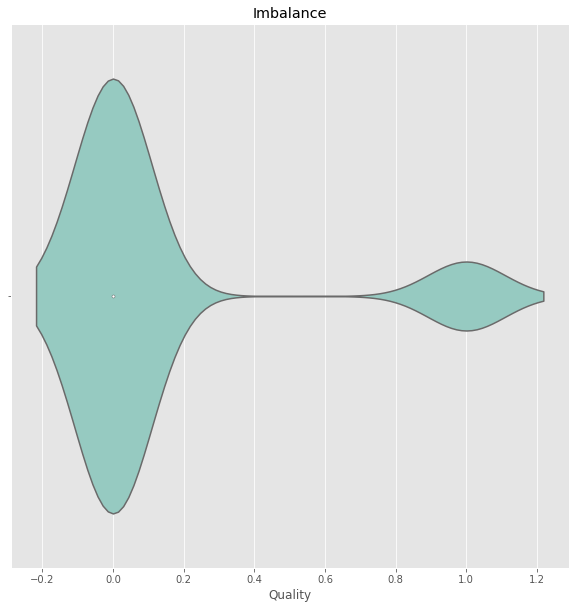

In [64]:
sns.violinplot(x=df_sw['Quality'],palette="Set3").set_title('Imbalance')

In [65]:
#check for missing data
for col in df_sw.columns:
    pct_missing = np.mean(df_sw[col].isnull())
    print('{} - {}%'.format(col,(pct_missing*100)))

Origin - 0.0%
Price - 1.2738853503184715%
Processing Method - 0.0%
Coffee Variety - 0.6369426751592357%
Fragrance - 0.0%
Aroma - 0.0%
Brightness - 0.0%
Flavor - 0.0%
Body - 0.0%
Finish - 0.0%
Sweetness - 0.0%
Clean Cup - 0.0%
Complexity - 0.0%
Uniformity - 0.0%
Cuppers Correction - 0.0%
Quality - 0.0%


In [66]:
#check for types of data
print(df_sw.shape)
print(df_sw.dtypes)

(314, 16)
Origin                 object
Price                 float64
Processing Method      object
Coffee Variety         object
Fragrance             float64
Aroma                 float64
Brightness            float64
Flavor                float64
Body                  float64
Finish                float64
Sweetness             float64
Clean Cup             float64
Complexity            float64
Uniformity            float64
Cuppers Correction    float64
Quality                 int32
dtype: object


In [67]:
#Renaming columns to python standards
df_sw.rename(columns = {'Coffee Variety' : 'Coffee_variety', 'Cuppers Correction' : 'Cuppers_correction','Processing Method' : 'Processing_method','Clean Cup' : 'Clean_cup'}, inplace = True)
df_sw = df_sw.drop(['Price', 'Origin'], axis=1)

In [68]:
for col in df_sw.columns:
    pct_missing = np.mean(df_sw[col].isnull())
    print('{} - {}%'.format(col,(pct_missing*100)))

Processing_method - 0.0%
Coffee_variety - 0.6369426751592357%
Fragrance - 0.0%
Aroma - 0.0%
Brightness - 0.0%
Flavor - 0.0%
Body - 0.0%
Finish - 0.0%
Sweetness - 0.0%
Clean_cup - 0.0%
Complexity - 0.0%
Uniformity - 0.0%
Cuppers_correction - 0.0%
Quality - 0.0%


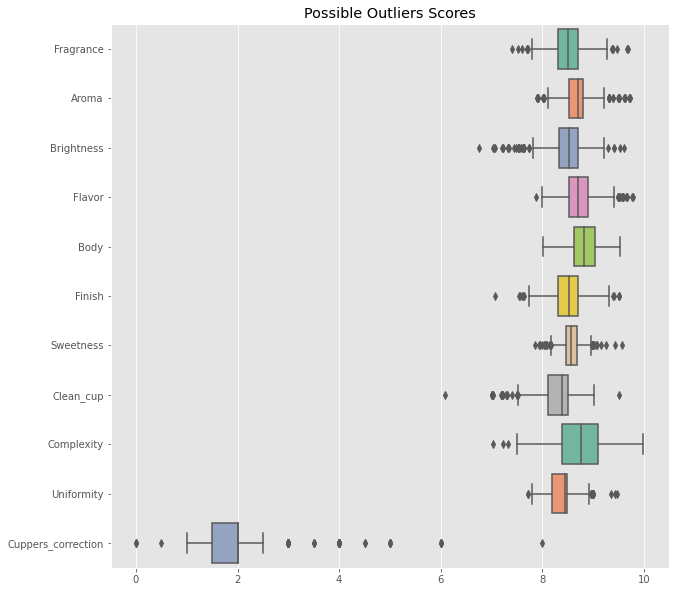

In [69]:
#check for possible outliers
sns.boxplot(data=df_sw.drop(['Quality','Processing_method'], axis=1), orient="h", palette="Set2").set_title('Possible Outliers Scores')
plt.savefig('sw_outlier.png',bbox_inches='tight')

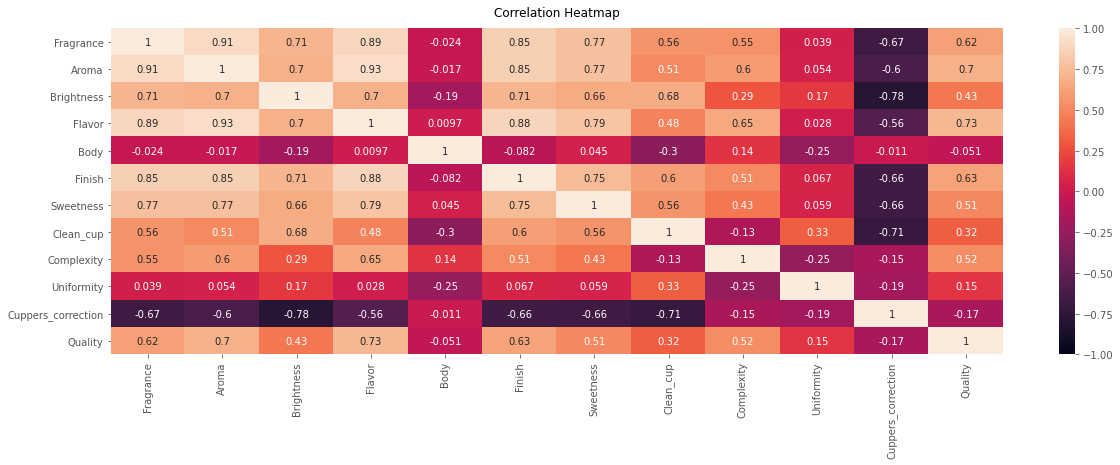

In [70]:
#check for correlation
plt.figure(figsize=(20, 6))
heatmap = sns.heatmap(df_sw.corr(), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig('sw_correlation_map.png', bbox_inches='tight')

In [71]:
#Check for amount of different processing methods
print(df_sw['Processing_method'].nunique())

12


In [72]:
#Check for amount of different coffee varieties
print(df_sw['Coffee_variety'].nunique())

30


In [73]:
#one hot encoding processing method and color
#sw_method = pd.get_dummies(df_sw.Processing_method, prefix = 'method')
#df_sw = df_sw.merge(sw_method,left_index=True, right_index=True)
df_sw = df_sw.drop(labels=['Processing_method','Coffee_variety'], axis=1)
df_sw.head()

,Fragrance,Aroma,Brightness,Flavor,Body,Finish,Sweetness,Clean_cup,Complexity,Uniformity,Cuppers_correction,Quality
0,9.679431,9.723152,8.815105,9.784969,9.215283,9.512979,9.156309,8.703897,9.796187,8.512686,0.5,1
1,9.671383,9.715167,8.717967,9.763791,9.028846,9.504687,9.008586,9.511536,9.775099,8.502938,0.0,1
2,9.278408,9.504828,8.816962,9.671457,8.305072,9.500052,8.999788,9.012537,9.695953,8.514944,2.0,1
3,9.374258,9.623292,8.727155,9.670841,9.215216,9.193867,8.986942,8.207776,9.796334,8.204318,2.0,1
4,9.274965,9.501295,8.726147,9.492756,9.512496,9.025716,8.985390,8.496914,9.779920,8.204402,2.0,1


In [74]:
#Extract independent and dependent features
X_sw =df_sw.drop(labels=['Quality'], axis=1)
y_sw =df_sw['Quality']

#Create numpy arrays for them
X_sw_arr= X_sw.to_numpy()
y_sw_arr= y_sw.to_numpy()

In [75]:
#Use standard scaler on Sweet Maria's Dataset
scaler = StandardScaler()
scaler.fit(X_sw.fillna(0))

StandardScaler()

In [76]:
#Balance over minority classes by oversampling
oversample = SMOTE()
X_sw, y_sw = oversample.fit_resample(X_sw, y_sw)

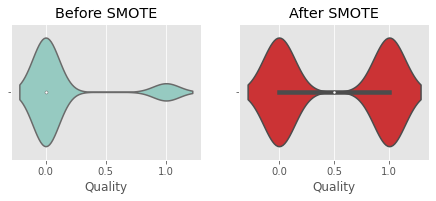

In [77]:
fig, axs = plt.subplots(ncols=2,figsize=(7.5,2.5))
sns.violinplot(x=df_sw['Quality'],ax=axs[0],palette="Set3").set_title('Before SMOTE')
sns.violinplot(x=y_sw,ax=axs[1],palette="Set1").set_title('After SMOTE')
fig.savefig('SMOTE balanced2')

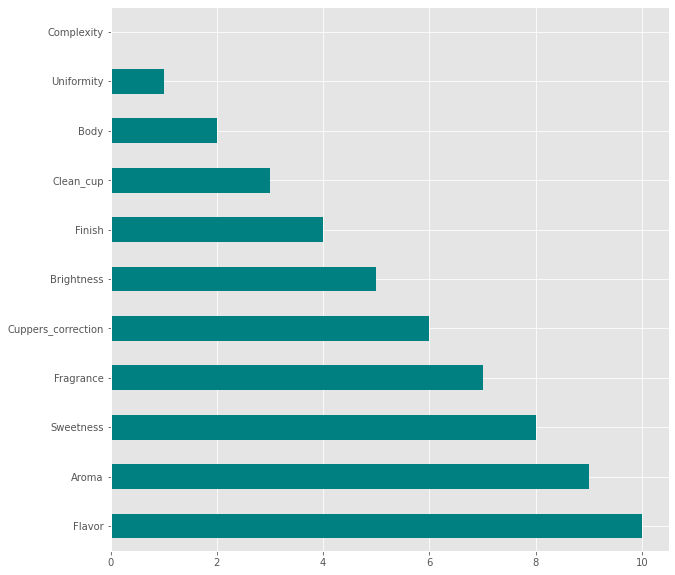

In [78]:
#check fisher scores ranking
ranks_sw= fisher_score.fisher_score(X_sw_arr,y_sw_arr)

FS_importance_sw= pd.Series (ranks_sw, df_sw.columns[0:len(df_sw.columns)-1]).sort_values(ascending=False)
FS_importance_sw.plot(kind='barh',color='teal')
plt.show()

In [79]:
#split data in train test
X_train, X_test, y_train, y_test = train_test_split(X_sw, y_sw, test_size=0.2, random_state=7)

In [80]:
#train random forest classifier for classification of outstanding specialty coffee
clf_sw = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_leaf=1, max_features='sqrt', random_state=7)
clf_sw.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf_sw.score(X_test, y_test)))

Accuracy on test data: 0.98


In [81]:
#perform feature permutation on sweet maria's dataset
result_sw = permutation_importance(clf_sw, X_train, y_train, n_repeats=100,
                                random_state=7)
perm_sorted_idx_sw = result_sw.importances_mean.argsort()

tree_importance_sorted_idx_sw = np.argsort(clf_sw.feature_importances_)
tree_indices_sw = np.arange(0, len(clf_sw.feature_importances_)) 


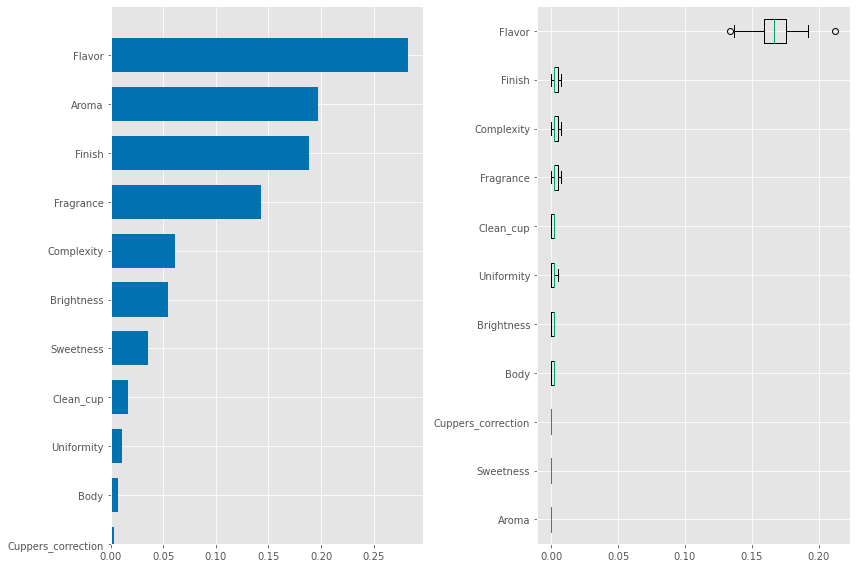

In [82]:
#compare feature permutation vs impurity based importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices_sw,
         clf_sw.feature_importances_[tree_importance_sorted_idx_sw], height=0.7)
ax1.set_yticks(tree_indices_sw)
ax1.set_yticklabels([list(X_sw.columns)[i] for i in tree_importance_sorted_idx_sw])
ax1.set_ylim((0, len(clf_sw.feature_importances_)))
ax2.boxplot(result_sw.importances[perm_sorted_idx_sw].T, vert=False,
            labels=[list(X_sw.columns)[i] for i in perm_sorted_idx_sw])
fig.tight_layout()
plt.show()

In [83]:
#set grid of parameters
params = {
        'n_estimators':[100, 200, 300],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'lambda': [0.5, 1, 1.5],
        'alpha': [0.5, 1, 1.5]        
        }
folds = 10

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 7)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_sw,y_sw), random_state=7 )
random_search.fit(X_sw,y_sw)

[13:55:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001E508847C10>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.01,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, mis...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=

In [84]:
#extract best estimator
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 Best estimator:
XGBClassifier(alpha=1.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='', lambda=0.5,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=1.5, reg_lambda=0.5, scale_pos_weight=1,
              subsample=0.6, tree_method='exact', validate_parameters=1,
              verbosity=None)

 Best normalized gini score for 10-fold search with 8 parameter combinations:
0.993689986282579

 Best hyperparameters:
{'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 4, 'lambda': 0.5, 'gamma': 1, 'colsample_bytree': 0.6, 'alpha': 1.5}


In [85]:
#set params
params = {
        'subsample': 0.6, 
        'n_estimators': 300, 
        'min_child_weight': 1, 
        'max_depth': 4, 
        'lambda': 1.5, 
        'gamma': 2, 
        'colsample_bytree': 0.8, 
        'alpha': 1.5,
         }       
           
          
# instantiate the classifier 
xgb_clf_sw = XGBClassifier(**params,use_label_encoder=False, random_state = 7)

output_sw = cross_validate(xgb_clf_sw, X_sw, y_sw, cv=10, scoring = 'accuracy', return_estimator =True)

[13:55:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:55:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:55:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:55:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [86]:
lista=[]
for ind,estimator in enumerate(output_sw['estimator']):
    #print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = list(X_sw.columns),
                                        columns=['importance']).sort_values('importance', ascending=False)
    lista.append(feature_importances)

In [87]:
#Create table with accuracy table from 10 folds
XGB_clf_sw= pd.concat([lista[0],lista[1],lista[2],lista[3],lista[4],lista[5],lista[6],lista[7],lista[8],lista[9]], axis=1)

#Create column and sort by average
XGB_clf_sw['Average'] = XGB_clf_sw.mean(axis=1)
XGB_clf_sw = XGB_clf_sw.loc[:,['Average']].sort_values('Average', ascending=False)

Text(0, 0.5, 'Features')

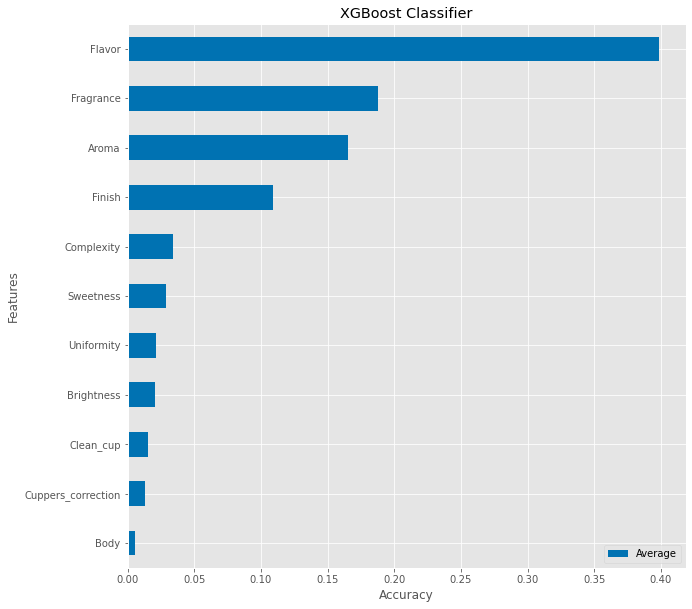

In [88]:
#Sweet Marias XGBoost classifier
XGB_clf_sw.sort_values('Average', ascending=True).plot(kind="barh", title="test")
plt.title("XGBoost Classifier")
plt.xlabel("Accuracy")
plt.ylabel("Features")

In [89]:
#Extracted ranking from Fischer Scores
fs_rank_sw=list(FS_importance_sw.sort_values(ascending=True).index)

#Extracted ranking from feature Permutation
feat_perm_rank_sw=[list(X_sw.columns)[i] for i in perm_sorted_idx_sw][::-1]

#Extracted ranking from XGBoost
xgb_rank_sw=list(XGB_clf_sw.index.values)



In [90]:
fs_rank_sw

['Complexity',
 'Uniformity',
 'Body',
 'Clean_cup',
 'Finish',
 'Brightness',
 'Cuppers_correction',
 'Fragrance',
 'Sweetness',
 'Aroma',
 'Flavor']

In [91]:
feat_perm_rank_sw

['Flavor',
 'Finish',
 'Complexity',
 'Fragrance',
 'Clean_cup',
 'Uniformity',
 'Brightness',
 'Body',
 'Cuppers_correction',
 'Sweetness',
 'Aroma']

In [92]:
xgb_rank_sw

['Flavor',
 'Fragrance',
 'Aroma',
 'Finish',
 'Complexity',
 'Sweetness',
 'Uniformity',
 'Brightness',
 'Clean_cup',
 'Cuppers_correction',
 'Body']

In [93]:
#perform feature ablation from most important to least improtant
sw_xgb= full_classifier(X_sw, y_sw, xgb_rank_sw, 10)
sw_feat_perm = full_classifier(X_sw, y_sw, feat_perm_rank_sw, 10)
sw_fs = full_classifier(X_sw, y_sw, fs_rank_sw, 10)


In [94]:
#perform feature ablation from least important to most important
sw_xgb_back = full_classifier(X_sw, y_sw, xgb_rank_sw[::-1], 10)
sw_feat_perm_back = full_classifier(X_sw, y_sw, feat_perm_rank_sw[::-1], 10)
sw_fs_back = full_classifier(X_sw, y_sw, fs_rank_sw[::-1], 10)

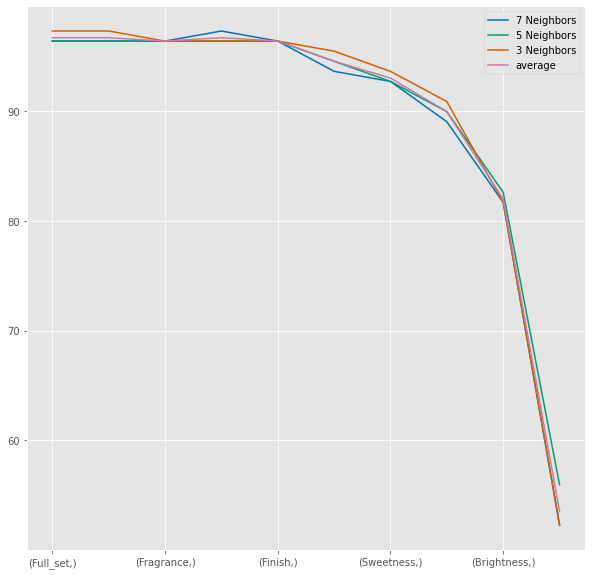

In [95]:
sw_xgb.T.plot()

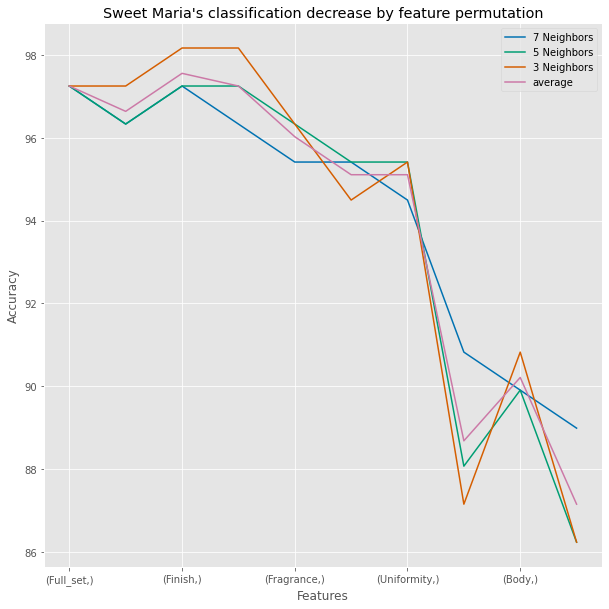

In [96]:
fig = (sw_feat_perm.T).plot()
plt.style.use('seaborn-colorblind')
plt.title("Sweet Maria's classification decrease by feature permutation")
plt.xlabel("Features")
plt.ylabel("Accuracy")
plt.savefig('sw_perm_classification', bbox_inches='tight')
plt.show()
